## 用异常值寻找交易信号？
## 思路是：
## 当某日涨跌幅大于过去N天的涨跌幅均值+3个标准差，则卖出
## 当某日涨跌幅小于过去N天的涨跌幅均值-3个标准差，则买入
## 下面来看如何用代码实现

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'#非MAC不需要这一行

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [15]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [6,4]
plt.rcParams['figure.dpi'] = 150

In [4]:
end = datetime.datetime.today()
start = datetime.datetime(end.year-1,end.month, end.day)

In [5]:
btc = yf.download('btc-usd',
                 start,
                 end)
btc.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-10,58250.871094,59519.355469,54071.457031,55859.796875,55859.796875,71776546298
2021-05-11,55847.242188,56872.542969,54608.652344,56704.574219,56704.574219,61308396325
2021-05-12,56714.531250,57939.363281,49150.535156,49150.535156,49150.535156,75215403907
2021-05-13,49735.433594,51330.843750,46980.019531,49716.191406,49716.191406,96721152926
2021-05-14,49954.574219,50737.371094,48929.195312,50737.371094,50737.371094,74930282496


In [6]:
btc['simple return'] = btc['Adj Close'].pct_change()
btc['log return'] = np.log(btc['Adj Close']/btc['Adj Close'].shift(1))
btc.tail()

,Open,High,Low,Close,Adj Close,Volume,simple return,log return
Date,,,,,,,,
2021-05-10,58250.871094,59519.355469,54071.457031,55859.796875,55859.796875,71776546298,-0.040742,-0.041596
2021-05-11,55847.242188,56872.542969,54608.652344,56704.574219,56704.574219,61308396325,0.015123,0.015010
2021-05-12,56714.531250,57939.363281,49150.535156,49150.535156,49150.535156,75215403907,-0.133217,-0.142967
2021-05-13,49735.433594,51330.843750,46980.019531,49716.191406,49716.191406,96721152926,0.011509,0.011443
2021-05-14,49954.574219,50737.371094,48929.195312,50737.371094,50737.371094,74930282496,0.020540,0.020332


In [7]:
btc_rolling = btc[['simple return']].rolling(window=60).agg(['mean', 'std'])
btc_rolling.tail()

simple return          
                    mean       std
Date                              
2021-05-10      0.000035  0.035295
2021-05-11      0.000423  0.035331
2021-05-12     -0.002934  0.038231
2021-05-13     -0.002214  0.038087
2021-05-14     -0.000918  0.037501

In [8]:
btc_rolling.columns = btc_rolling.columns.droplevel()
btc_rolling.tail()

,mean,std
Date,,
2021-05-10,0.000035,0.035295
2021-05-11,0.000423,0.035331
2021-05-12,-0.002934,0.038231
2021-05-13,-0.002214,0.038087
2021-05-14,-0.000918,0.037501


In [9]:
btc_outliers = btc.join(btc_rolling)
btc_outliers.tail()

,Open,High,Low,Close,Adj Close,Volume,simple return,log return,mean,std
Date,,,,,,,,,,
2021-05-10,58250.871094,59519.355469,54071.457031,55859.796875,55859.796875,71776546298,-0.040742,-0.041596,0.000035,0.035295
2021-05-11,55847.242188,56872.542969,54608.652344,56704.574219,56704.574219,61308396325,0.015123,0.015010,0.000423,0.035331
2021-05-12,56714.531250,57939.363281,49150.535156,49150.535156,49150.535156,75215403907,-0.133217,-0.142967,-0.002934,0.038231
2021-05-13,49735.433594,51330.843750,46980.019531,49716.191406,49716.191406,96721152926,0.011509,0.011443,-0.002214,0.038087
2021-05-14,49954.574219,50737.371094,48929.195312,50737.371094,50737.371094,74930282496,0.020540,0.020332,-0.000918,0.037501


In [10]:
def identify_outliers(row, n_sigmas=3):
    x = row['simple return']
    mu = row['mean']
    sigma = row['std']
    if (x > mu + 3 * sigma) | (x < mu - 3 * sigma):
        return 1
    else:
        return 0

In [11]:
btc_outliers['outliers'] = btc_outliers.apply(identify_outliers, axis = 1)
outliers = btc_outliers.loc[btc_outliers['outliers']==1, ['simple return']]

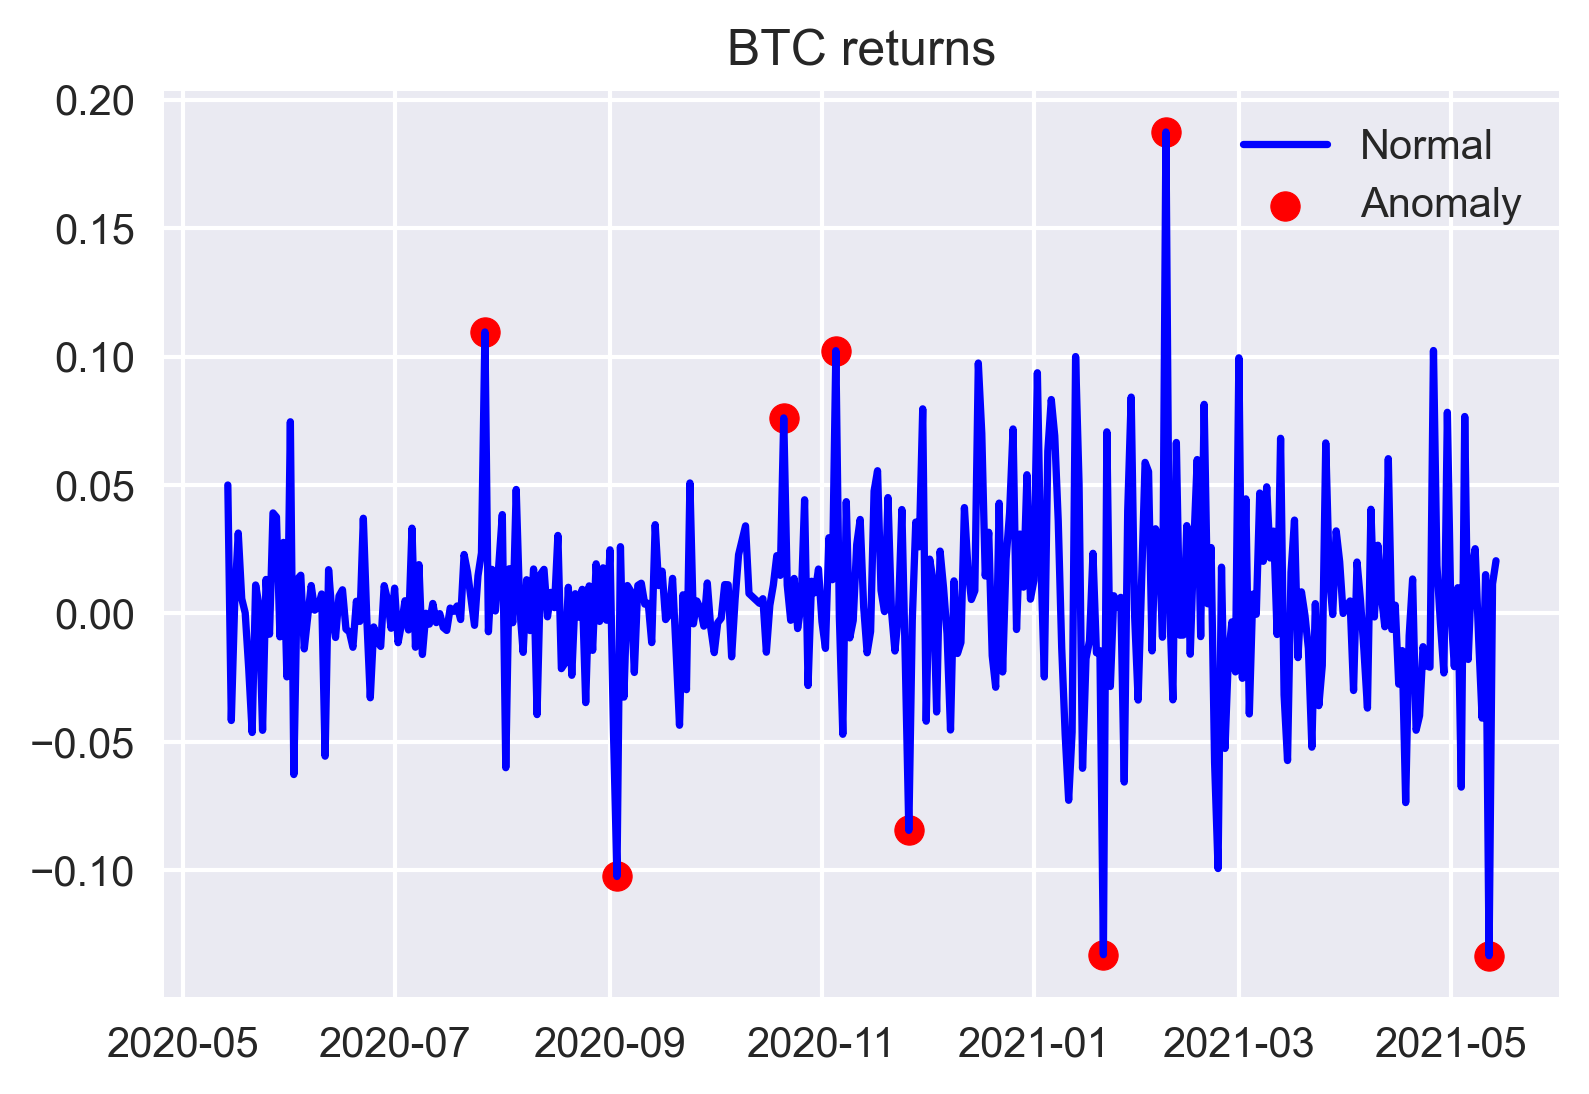

In [16]:
plt.plot(btc_outliers.index, btc_outliers['simple return'],
 color='blue', label='Normal')
plt.scatter(outliers.index, outliers['simple return'],
 color='red', label='Anomaly')
plt.title("BTC returns")
plt.legend(loc='best')